In [1]:
DATASET_NAME = "2.DRIVE_INSPECT" # DRIVE, CVC_ClinicDB, LUNGS, ISIC2018, ISBI2012_EM

In [2]:
# Import libraries

import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline
import numpy as np
from skimage.transform import resize
import time
from tqdm import tqdm
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import callbacks
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from keras.models import load_model

import models as M
import losses as l

ROOT_DIR = os.path.abspath("./")
LOG_PATH = os.path.join(ROOT_DIR, "logs")
TARGET_PATH = os.path.join(LOG_PATH, "{}".format(DATASET_NAME))
print(os.listdir(TARGET_PATH))

Using TensorFlow backend.


['DRIVE_Unet.h5', 'EM_lgraph.pdf', 'DRIVE_Gauss_Unet_predicted_masks.npy', 'DRIVE_Gauss_Unet_REPORT.txt', 'DRIVE_Gauss_Unet_loss.txt', 'DRIVE_Unet_jacard.txt', 'DRIVE_Gauss_Unet_jacard.txt', 'DRIVE_Unet_REPORT.txt', 'DRIVE_Gauss_Unet_inputs.npy', 'DRIVE_Unet_inputs.npy', 'DRIVE_Unet_predicted_masks.npy', 'DRIVE_Unet_loss.txt', 'DRIVE_Unet_masks.npy', 'DRIVE_seg_vis.pdf', 'DRIVE_Gauss_Unet.h5', 'DRIVE_Gauss_Unet_masks.npy', 'OCT_jgraph.pdf']


In [3]:
def read_txt(path, loss):
    
    data = []
    with open(path, 'r') as f:
        for line in f:
            
            if loss != True:
                line = float(line[:4]) * 10
            else:
                line = float(line[:4]) / 10
            
            data.append(line)
        f.close()
    
    return data

### Cross validation best fold plotted

In [4]:
# Read Jaccard and Loss
ujp = read_txt(os.path.join(TARGET_PATH, "DRIVE_Unet_jacard.txt"), loss=False)
ulp = read_txt(os.path.join(TARGET_PATH, "DRIVE_Unet_loss.txt"), loss=True)
gjp = read_txt(os.path.join(TARGET_PATH, "DRIVE_Gauss_Unet_jacard.txt"), loss=False)
glp = read_txt(os.path.join(TARGET_PATH, "DRIVE_Gauss_Unet_loss.txt"), loss=True)

len(ujp), len(ulp), len(gjp), len(glp)

(126, 126, 117, 117)

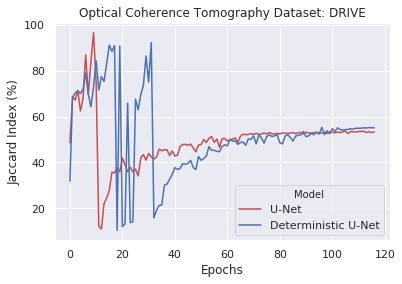

In [5]:
interval = min(len(ujp), len(gjp))
epochs = range(interval)
plt.plot(epochs, ujp[:interval], 'r')
plt.plot(epochs, gjp[:interval], 'b')

plt.title('Optical Coherence Tomography Dataset: DRIVE')
plt.ylabel('Jaccard Index (%)')
plt.xlabel('Epochs')
plt.legend(['U-Net', 'Deterministic U-Net'], title="Model", loc='lower right')
plt.savefig('{}/OCT_jgraph.pdf'.format(TARGET_PATH), dpi=100)

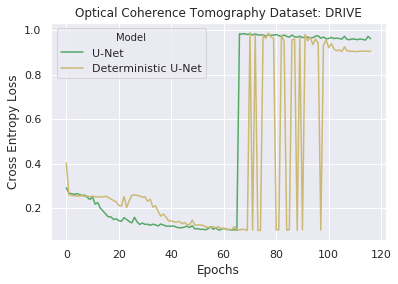

In [6]:
interval = min(len(ulp), len(glp))
epochs = range(interval)
plt.plot(epochs, ulp[:interval], 'g')
plt.plot(epochs, glp[:interval], 'y')

plt.title('Optical Coherence Tomography Dataset: DRIVE')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epochs')
plt.legend(['U-Net', 'Deterministic U-Net'], title="Model", loc='upper left')
plt.savefig('{}/EM_lgraph.pdf'.format(TARGET_PATH), dpi=100)

In [7]:
TARGET_PATH

'/home/hasib/gaussianU-Net/logs/2.DRIVE_INSPECT'

In [8]:
# Load Input images and gt masks from Unet
images = np.load("{}/DRIVE_Unet_inputs.npy".format(TARGET_PATH))
masks = np.load("{}/DRIVE_Unet_masks.npy".format(TARGET_PATH))
images.shape, masks.shape

((8, 512, 512, 3), (8, 512, 512, 1))

In [9]:
# Load unet predictions
u_preds = np.load("{}/DRIVE_Unet_predicted_masks.npy".format(TARGET_PATH))
u_preds.shape

(8, 512, 512, 1)

In [10]:
# Load Gauss Unet model
model = None
model = load_model("{}/DRIVE_Gauss_Unet.h5".format(TARGET_PATH), compile=False)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [11]:
# Gauss Unet predictions
preds = model.predict(x=images, verbose=1)
preds = np.round(preds,0)
preds.shape

8/8 [==============================] - 12s 1s/step


(8, 512, 512, 1)

In [12]:
images.shape, masks.shape, u_preds.shape, preds.shape

((8, 512, 512, 3), (8, 512, 512, 1), (8, 512, 512, 1), (8, 512, 512, 1))

In [13]:
def compute_jac(y, yhat):
    intersection = yhat.ravel() * y.ravel()
    union = yhat.ravel() + y.ravel() - intersection
    jacard = (np.sum(intersection)/np.sum(union))
    return jacard

In [15]:
# Check
#compute_jac(masks[0], masks[0])

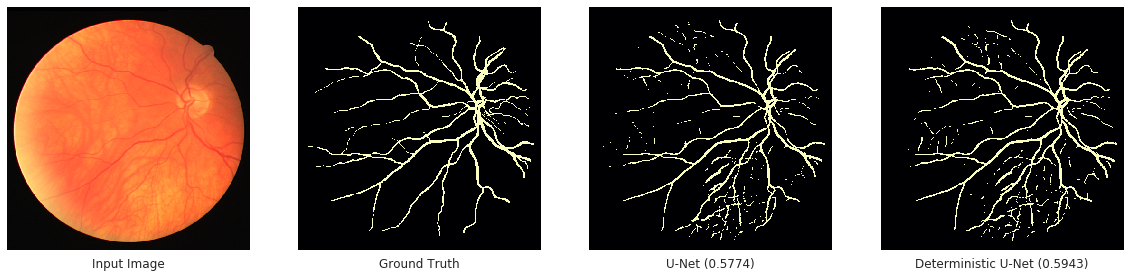

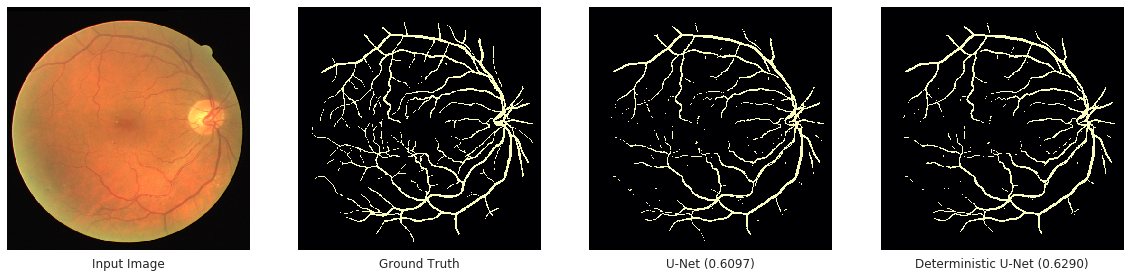

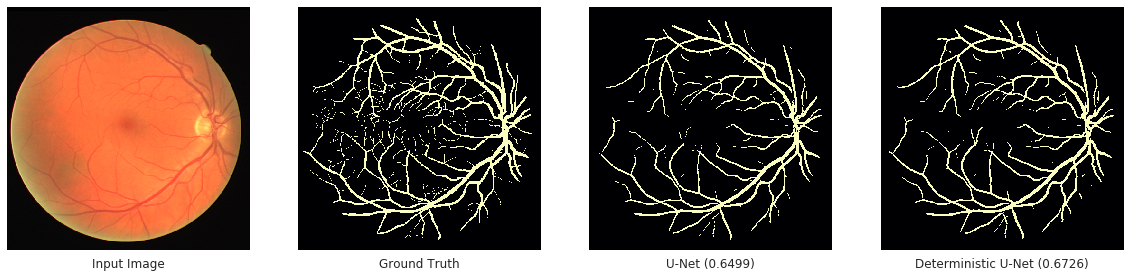

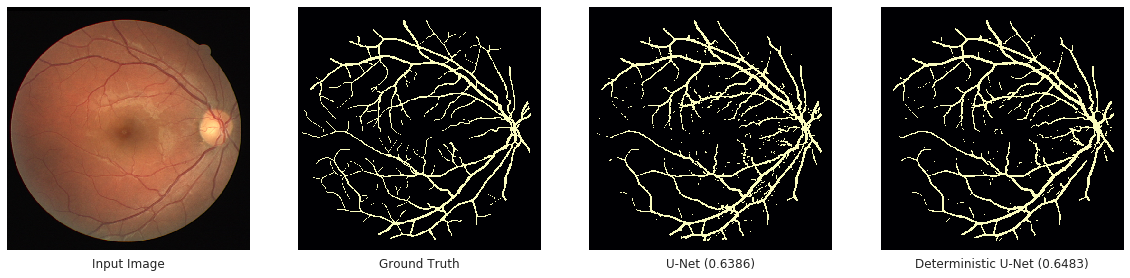

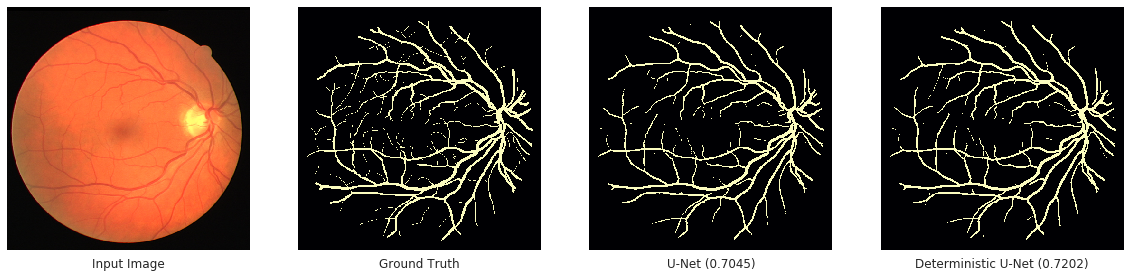

In [17]:
for i in range(5):
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,4,1)
    if len(images[i].shape) >= 2:
        plt.grid(False)
        plt.axis('off')
        plt.imshow(images[i].squeeze(), cmap='gray') # 1-channel image
    else:
        plt.grid(False)
        plt.axis('off')
        plt.imshow(images[i]) # 3-channel
        
    plt.title('Input Image', y=-0.1)
    plt.subplot(1,4,2)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(masks[i].reshape(masks[i].shape[0],masks[i].shape[1]), cmap='magma')
    plt.title('Ground Truth', y=-0.1)
    
    plt.subplot(1,4,3)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(u_preds[i].reshape(u_preds[i].shape[0],u_preds[i].shape[1]), cmap='magma')
    
    jac = compute_jac(masks[i], u_preds[i])
    plt.title('U-Net ({0:.4f})'.format(jac), y=-0.1)
    
    plt.subplot(1,4,4)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(preds[i].reshape(preds[i].shape[0],preds[i].shape[1]), cmap='magma')
    
    jac = compute_jac(masks[i], preds[i])
    plt.title('Deterministic U-Net ({0:.4f})'.format(jac), y=-0.1)
    
    plt.show()
    plt.close()

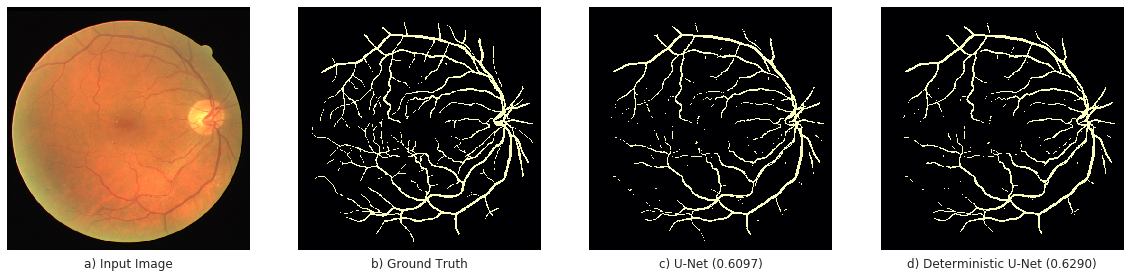

In [18]:
i = 1

plt.figure(figsize=(20,10))
plt.subplot(1,4,1)
if len(images[i].shape) >= 2:
    plt.grid(False)
    plt.axis('off')
    plt.imshow(images[i].squeeze(), cmap='gray') # 1-channel image
else:
    plt.grid(False)
    plt.axis('off')
    plt.imshow(images[i]) # 3-channel

plt.title('a) Input Image', y=-0.1)
plt.subplot(1,4,2)
plt.grid(False)
plt.axis('off')
plt.imshow(masks[i].reshape(masks[i].shape[0],masks[i].shape[1]), cmap='magma')
plt.title('b) Ground Truth', y=-0.1)

plt.subplot(1,4,3)
plt.grid(False)
plt.axis('off')
plt.imshow(u_preds[i].reshape(u_preds[i].shape[0],u_preds[i].shape[1]), cmap='magma')

jac = compute_jac(masks[i], u_preds[i])
plt.title('c) U-Net ({0:.4f})'.format(jac), y=-0.1)

plt.subplot(1,4,4)
plt.grid(False)
plt.axis('off')
plt.imshow(preds[i].reshape(preds[i].shape[0],preds[i].shape[1]), cmap='magma')

jac = compute_jac(masks[i], preds[i])
plt.title('d) Deterministic U-Net ({0:.4f})'.format(jac), y=-0.1)

plt.savefig('{}/DRIVE_seg_vis.pdf'.format(TARGET_PATH), bbox_inches='tight', dpi=100)
plt.show()
plt.close()

In [19]:
masks.shape, u_preds.shape, preds.shape

((8, 512, 512, 1), (8, 512, 512, 1), (8, 512, 512, 1))

In [20]:
y_true = masks.ravel() 
y_1 = u_preds.ravel() 
y_2 = preds.ravel() 

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [22]:
def get_res(y, yhat):
    
    fpr, tpr, thresholds = roc_curve((y), yhat)
    AUC_ROC = roc_auc_score(y, yhat)
    
    y_scores= yhat
    y_true = y 
    
    #Confusion matrix
    threshold_confusion = 0.5
    #print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
    y_pred = np.empty((y_scores.shape[0]))
    for i in range(y_scores.shape[0]):
        if y_scores[i]>=threshold_confusion:
            y_pred[i]=1
        else:
            y_pred[i]=0
    confusion = confusion_matrix(y_true, y_pred)
    #print (confusion)
    accuracy = 0
    if float(np.sum(confusion))!=0:
        accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
    #print ("Global Accuracy: " +str(accuracy))
    specificity = 0
    if float(confusion[0,0]+confusion[0,1])!=0:
        specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
    #print ("Specificity: " +str(specificity))
    sensitivity = 0
    if float(confusion[1,1]+confusion[1,0])!=0:
        sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
    #print ("Sensitivity: " +str(sensitivity))
    precision = 0
    if float(confusion[1,1]+confusion[0,1])!=0:
        precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
    #print ("Precision: " +str(precision))
    

    #F1 score
    F1_score = f1_score(y_true, y_scores, labels=None, average='binary', sample_weight=None)
    #print ("\nF1 score (F-measure): " +str(F1_score))
    
    return round(F1_score, 4), round(sensitivity, 4), round(specificity, 4), round(accuracy, 4), round(AUC_ROC, 4)
    

In [23]:
# Unet
F1_score, sensitivity, specificity, accuracy, AUC_ROC = get_res(y_true, y_1)
print(F1_score, sensitivity, specificity, accuracy, AUC_ROC)

0.7832 0.7305 0.9866 0.9634 0.8585


In [24]:
# Deterministic U-Net
F1_score, sensitivity, specificity, accuracy, AUC_ROC = get_res(y_true, y_2)
print(F1_score, sensitivity, specificity, accuracy, AUC_ROC)

0.7926 0.759 0.9845 0.964 0.8717
